# **LLM Application - Sentiment Analysis**

Sentiment analysis is the task of determining the emotional tone or sentiment expressed in a piece of text.

## *Import and Load Dataset*

In [ ]:
%%capture

!pip install datasets

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import load_dataset, Dataset

# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the full dataset
full_data = load_dataset("stanfordnlp/imdb", split='train')

# Convert to pandas DataFrame
df = pd.DataFrame(full_data)

# Split the data into train and test while preserving class distribution
train_df, test_df = train_test_split(df, test_size=0.02, stratify=df['label'])
unsupervised_df = df.drop(test_df.index)

# Convert back to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
unsupervised_dataset = Dataset.from_pandas(unsupervised_df)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_labels = [example['label'] for example in train_dataset]
test_labels = [example['label'] for example in test_dataset]
unsupervised_labels = [example['label'] for example in unsupervised_dataset]

print("Train class distribution:", Counter(train_labels))
print("Test class distribution:", Counter(test_labels))
print("Unsupervised class distribution:", Counter(unsupervised_labels))

Train class distribution: Counter({0: 12250, 1: 12250})
Test class distribution: Counter({1: 250, 0: 250})
Unsupervised class distribution: Counter({0: 12250, 1: 12250})


## *Analysis The Train Dataset*

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 24500
})

In [ ]:
# Convert to pandas DataFrame for easier viewing and manipulation
train_df = pd.DataFrame(train_dataset)

# Display the first 5 rows of the training dataset
train_df.head()

,text,label,__index_level_0__
0,<br /><br />I'm not sure who decides what cate...,0,4364
1,This is the biggest piece of crap ever. It loo...,0,2884
2,He glorified himself as a great supporting act...,1,14355
3,"this is a film about life, the triumph over ad...",1,14344
4,"Jesus Christ, I can't believe I've wasted my t...",0,12035


In [ ]:
import numpy as np

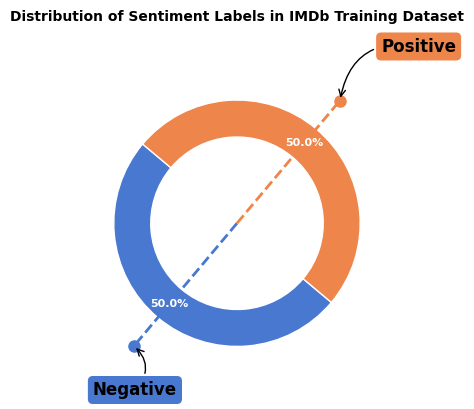

In [ ]:
# Map the labels to 'Positive' and 'Negative'
train_df['sentiment'] = train_df['label'].map({1: 'Positive', 0: 'Negative'})

# Visualize the distribution of labels as a pie chart with enhancements
fig, ax = plt.subplots(figsize=(4, 4))
colors = sns.color_palette("muted")
labels = train_df['sentiment'].value_counts().index
sizes = train_df['sentiment'].value_counts().values

# Create the pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    pctdistance=0.85
)

# Draw lines and markers
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
    x = wedge.r * 1.3 * np.cos(np.deg2rad(angle))
    y = wedge.r * 1.3 * np.sin(np.deg2rad(angle))
    ax.plot([0, x], [0, y], color=colors[i], lw=2, linestyle='--')
    ax.plot([x], [y], marker='o', markersize=8, color=colors[i])

# Annotate with labels
for i, (wedge, text, autotext) in enumerate(zip(wedges, texts, autotexts)):
    text.set_fontsize(8)
    autotext.set_fontsize(8)
    autotext.set_color('white')
    autotext.set_weight('bold')
    x = wedge.r * 1.3 * np.cos(np.deg2rad((wedge.theta2 + wedge.theta1) / 2.))
    y = wedge.r * 1.3 * np.sin(np.deg2rad((wedge.theta2 + wedge.theta1) / 2.))
    ax.annotate(
        labels[i],
        xy=(x, y),
        xytext=(1.4 * x, 1.4 * y),
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor=colors[i]),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"),
        fontsize=12, weight='bold', color='black'
    )

# Add title with space for annotations
plt.title('Distribution of Sentiment Labels in IMDb Training Dataset', fontsize=10, fontweight='bold', pad=35)

# Set aspect ratio to be equal
ax.set_aspect('equal')

plt.show()

From the above plot it is clear that the data is balanced well with both sentiment class in equal percentage.

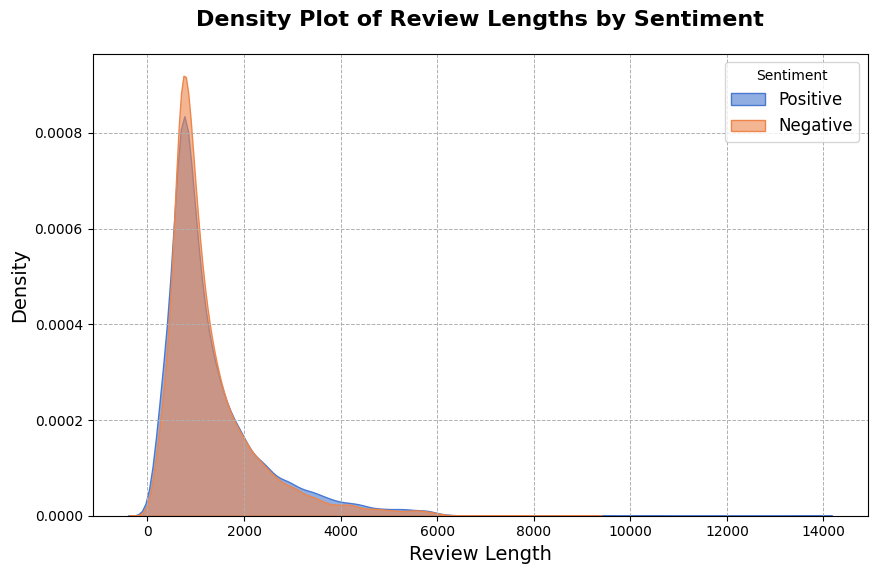

In [ ]:
# Compute review lengths
train_df['review_length'] = train_df['text'].apply(len)

# Map the labels to 'Positive' and 'Negative'
train_df['sentiment'] = train_df['label'].map({1: 'Positive', 0: 'Negative'})

# Create a density plot for review lengths
plt.figure(figsize=(10, 6))
palette = sns.color_palette("muted")

# Plot density plots for each sentiment
sns.kdeplot(data=train_df[train_df['sentiment'] == 'Positive'], x='review_length',
            fill=True, color=palette[0], label='Positive', alpha=0.6)
sns.kdeplot(data=train_df[train_df['sentiment'] == 'Negative'], x='review_length',
            fill=True, color=palette[1], label='Negative', alpha=0.6)

# Add title and labels
plt.title('Density Plot of Review Lengths by Sentiment', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Review Length', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7)

# Show the plot
plt.show()

The image shows that both positive and negative reviews tend to be shorter, with a longer tail for negative reviews.










## *Tokenization*

Tokenization is the process of converting text into smaller units, like words or subwords, to make it suitable for model input.

`DistilBertTokenizer` is a tokenizer specifically designed for the DistilBERT model, which converts text into token IDs compatible with DistilBERT.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset

# Step 1: Load the Pre-trained Tokenizer
# Initialize the DistilBer tokenizer with the pre-trained 'distilbert-base-uncased' model.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Step 2: Define the Tokenization Function
def tokenize_function(examples):
    """
    This function takes a batch of examples from the dataset and tokenizes the 'text' field.

    Args:
        examples (dict): A dictionary containing a list of text examples under the 'text' key.

    Returns:
        dict: A dictionary with the tokenized inputs and attention masks.
    """
    # Tokenize the text data with padding and truncation
    # `padding='max_length'` pads sequences to the maximum length specified by the tokenizer
    # `truncation=True` ensures that sequences longer than the model's maximum length are truncated
    return tokenizer(
        examples['text'],  # The key in the examples dictionary that contains the text to tokenize
        padding='max_length',  # Pad to the maximum length of the tokenizer
        truncation=True,  # Truncate texts that exceed the maximum length
        max_length=128  # Optional: Specify the maximum length of the sequences (adjust as needed)
    )

# Step 4: Apply Tokenization to the Dataset
# Use the `map` method to apply the `tokenize_function` to each example in the dataset
# `batched=True` processes multiple examples at once for efficiency
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Output the structure of the tokenized datasets
print("Tokenized train dataset format:", tokenized_train.features)
print("Tokenized test dataset format:", tokenized_test.features)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/24500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenized train dataset format: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Tokenized test dataset format: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [ ]:
# Example of tokenized output for the first sample
first_sample = tokenized_train[0]
print("Tokenized sample:")
print("Text:", train_df['text'][0])
print("Input IDs:", first_sample['input_ids'])
print("Attention Mask:", first_sample['attention_mask'])

Tokenized sample:
Text: <br /><br />I'm not sure who decides what category a movie fits into, but this movie is NOT a horror movie. As for the story, it was fairly interesting, but rather slow. I was especially disappointed with the ending though.<br /><br />**spoiler**<br /><br />Tell me why on Earth does she run over to her uncle's(?) home without at least calling the detective or the police first? She knows exactly what's going on at that point, plus she has a video tape as proof. Instead, she runs over there and starts going nuts and saying "I know everything, I have proof! You didn't expect proof, did you?!" Then she acts surprised when her uncle stands up and starts walking over to her as if he's going to harm her. Well DUH! Of course he's going to harm you idiot, you just told him you know everything and have proof to expose everything. What a dumb ending.
Input IDs: [101, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1045, 1005, 1049, 2025, 2469, 2040, 7288, 2054, 4696, 1037,

input_ids: The tokenized representation of the text. Each integer represents a token ID as understood by BERT.

attention_mask: Indicates which tokens are actual data (1) and which are padding (0). This helps the model ignore padding tokens during processing.

## *DistilBert Model*

DistilBert is a smaller, faster version of BERT that retains 97% of BERT's language understanding while being more efficient.

In [ ]:
# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define the model configuration (optional)
from transformers import DistilBertConfig
config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2,
                                           id2label={0: 'negative', 1: 'positive'},
                                           label2id={'negative': 0, 'positive': 1},
                                           output_attentions=True,
                                           output_hidden_states=True)

# Initialize the model with the custom configuration
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

# Print model details
print(model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## *Training Arugments*

Training arguments are configurations that control various aspects of model training, such as learning rate, batch size, and number of epochs.

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model predictions and checkpoints
    evaluation_strategy="epoch",     # Evaluate the model at the end of each epoch
    learning_rate=2e-5,               # Learning rate for optimization
    per_device_train_batch_size=4,   # Batch size for training
    per_device_eval_batch_size=4,    # Batch size for evaluation
    num_train_epochs=1,              # Number of training epochs
    weight_decay=0.01,               # Weight decay for regularization
    logging_dir='./logs',            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    fp16=True,  # Enable mixed precision
)


## *Training Model*

`Trainer` from the `transformers` library is a high-level API for training and evaluating models with ease, including handling training loops, evaluation, and logging.

In [ ]:
from transformers import Trainer

# Use the revised data collator
train_model = Trainer(
   model=model, # The model to be trained
   args=training_args, # Training arguments
   train_dataset=tokenized_train,# Training dataset
   eval_dataset=tokenized_test, # Evaluation dataset
)


In [ ]:
# train the model trainer
train_model.train()

Epoch,Training Loss,Validation Loss
1,0.215400,0.442749


TrainOutput(global_step=6125, training_loss=0.4570160478085888, metrics={'train_runtime': 416.1848, 'train_samples_per_second': 58.868, 'train_steps_per_second': 14.717, 'total_flos': 811362816768000.0, 'train_loss': 0.4570160478085888, 'epoch': 1.0})

In [ ]:
from datasets import Dataset

# Create a Dataset object from a dictionary
test_dataset = Dataset.from_dict({
    'input_ids': tokenized_test['input_ids'],        # Token IDs for model input
    'attention_mask': tokenized_test['attention_mask']  # Attention masks to indicate which tokens should be attended to
})


In [ ]:
from transformers import Trainer

# Make predictions
predictions = train_model.predict(test_dataset)

# Extract logits (first element of the tuple)
logits = predictions.predictions[0]

# Compute predicted class indices
y_pred = logits.argmax(axis=-1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import torch

# Extract true labels from tokenized_test
y_true = tokenized_test['label']

# Convert to numpy array if it's a list
if isinstance(y_true, list):
    y_true = np.array(y_true)

# Ensure y_true is a 1D array of class indices
y_true = y_true.flatten()  # Flatten in case it's multi-dimensional

# Make predictions
predictions = train_model.predict(test_dataset)
logits = predictions.predictions[0]  # Extract logits from the tuple
y_pred = logits.argmax(axis=-1)  # Get predicted class indices

# Convert y_pred to numpy array if needed
if isinstance(y_pred, torch.Tensor):
    y_pred = y_pred.numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8640
Precision: 0.8655
Recall: 0.8640
F1 Score: 0.8639


In [ ]:
# Generate and print classification report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     0.8889    0.8320    0.8595       250
           1     0.8421    0.8960    0.8682       250

    accuracy                         0.8640       500
   macro avg     0.8655    0.8640    0.8639       500
weighted avg     0.8655    0.8640    0.8639       500



In [ ]:
# save model and tokenizer
model.save_pretrained('./fine-tuned-bert-imdb')
tokenizer.save_pretrained('./fine-tuned-bert-imdb')

('./fine-tuned-bert-imdb/tokenizer_config.json',
 './fine-tuned-bert-imdb/special_tokens_map.json',
 './fine-tuned-bert-imdb/vocab.txt',
 './fine-tuned-bert-imdb/added_tokens.json')

## *Test Case*

In [ ]:
# load tokeniezr and model
tokenizer = DistilBertTokenizer.from_pretrained('./fine-tuned-bert-imdb')
model = DistilBertForSequenceClassification.from_pretrained('./fine-tuned-bert-imdb')

In [ ]:
# tokenzie the input
def preprocess_function(sentence):
    return tokenizer(sentence, padding='max_length', truncation=True, return_tensors='pt')

### *Test Case 1*

In [ ]:
test_sentence = "I love this movie! It was fantastic."
inputs = preprocess_function(test_sentence)

In [ ]:
# Move model to evaluation mode
model.eval()

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get predicted class
predicted_class = torch.argmax(logits, dim=1).item()
labels = {0: 'negative', 1: 'positive'}
print(test_sentence)
print(f"Sentiment: {labels[predicted_class]}")

I love this movie! It was fantastic.
Sentiment: positive


### *Test Case 2*

In [ ]:
test_sentence1 = "The movie was a complete waste of time. I regret watching it."
inputs1 = preprocess_function(test_sentence1)

with torch.no_grad():
    outputs1 = model(**inputs1)
    logits1 = outputs1.logits

predicted_class1 = torch.argmax(logits1, dim=1).item()
print(test_sentence1)
print(f"Sentiment: {labels[predicted_class1]}")

The movie was a complete waste of time. I regret watching it.
Sentiment: negative


### *Test Case 3*

In [ ]:
test_sentence2 = "I didn't like the film at all. The plot was boring and predictable."
inputs2 = preprocess_function(test_sentence2)

with torch.no_grad():
    outputs2 = model(**inputs2)
    logits2 = outputs2.logits

predicted_class2 = torch.argmax(logits2, dim=1).item()
print(test_sentence2)
print(f"Sentiment: {labels[predicted_class2]}")

I didn't like the film at all. The plot was boring and predictable.
Sentiment: negative


### *Test Case 4*

In [ ]:
test_sentence3 = "What an amazing movie! The acting was superb and the story was gripping."
inputs3 = preprocess_function(test_sentence3)

with torch.no_grad():
    outputs3 = model(**inputs3)
    logits3 = outputs3.logits

predicted_class3 = torch.argmax(logits3, dim=1).item()
print(test_sentence3)
print(f"Sentiment: {labels[predicted_class3]}")

What an amazing movie! The acting was superb and the story was gripping.
Sentiment: positive


## *Challenges*


1. First challenge was that the project was not able to work on dataset more than 500 for test data for which only 500 test samples are used to test model also reducing the data for test.
2. Second was evaluating the mertics and few errors were occuring during the evaluation.